<img src="../style/img/vs265header.svg"/>

<h1 align="center">Lab 4 - Sparse, Distributed Representations</h1>

## Part 2 - Sparse Coding of Natural Images

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import utils.plotFunctions as pf
import utils.helperFunctions as hf
import scipy.io.wavfile as wav
import IPython
import os
import random

In [2]:
# General sparse coding parameters
numTrials = 600 # Number of weight learning steps
numInputs = 64#256 #1024 # 4096 #16384 # Number of input pixels, needs to have an even square root
numOutputs = 36 #number of sparse coding neurons
sparsityTradeoff = 0.2# YOUR CODE HERE # Lambda parameter that determines how sparse the model will be
batchSize = 1000 # How many image patches to include in batch
eta = 0.14 # Learning rate

# LCA specific parameters
tau = 50 # LCA update time constant
numSteps = 20 # Number of iterations to run LCA

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

mary had a little lamb.wav
262144
262144
262144
262144
262144
(262144, 5)


<IPython.core.display.Javascript object>


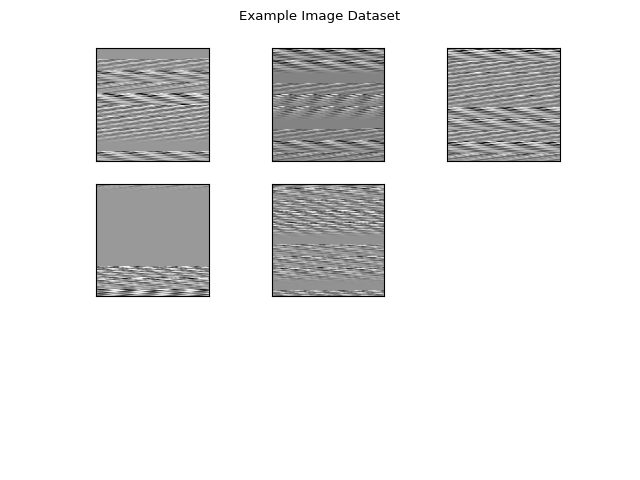

In [3]:
assert numInputs%np.sqrt(numInputs) == 0, (
    "numInputs must have an even square root.")

directory = "./trainWav"
songs = None
importDataset = None
numSongs = 0
sectionSize = 512**2
for file in os.listdir(directory):
    if file.endswith(".wav"):
        print(file)
        numSongs += 1
        rate, data = wav.read(directory + '/' + file)
        length = data.shape[0]
        if songs is None:
            songs = data[:, 0]
        else:
            songs = np.hstack((songs, data[:, 0]))
        
        numSubSections = int(length / sectionSize)
        for sectionNum in range(numSubSections - 2):
            start = sectionSize*sectionNum
            end = sectionSize*(sectionNum + 1)
            print(end - start)
            singleChannelData = data[start:end, 0]
            
            if importDataset is None:
                importDataset = singleChannelData[:]
            else:
#                 print(importDataset.shape)
#                 print(singleChannelData.shape)
                importDataset = np.vstack((importDataset, singleChannelData))
                
# importDataset = np.swapaxes(importDataset, 0, 1)
importDataset = importDataset.T
# normalizationFactor = np.mean(importDataset)
# normImportDataset = importDataset - normalizationFactor 
whitenFactor = np.sqrt(np.var(importDataset)) #np.true_divide(image, np.linalg.norm(image+0.0))
dataset = importDataset / whitenFactor # We want the dataset to have variance=1
print(dataset.shape)
# Note: Here you can index any image, or just delete the [:,0] part and plot all images
pf.plotDataTiled(dataset, "Example Image Dataset");
        



In [4]:
originalData = (dataset[:, 0, np.newaxis] * whitenFactor).astype(np.int16)
# originalData = originalData[::-1]
print(originalData.shape)
print(originalData.dtype)
print(rate)
wav.write('original.wav', rate, originalData)

(262144, 1)
int16
44100


In [5]:
IPython.display.Audio("original.wav")

In [6]:

def lcaSparsifyAudio(data, phi, tau, sparsityTradeoff, numSteps, strict = False):
    """
    Compute sparse code of input data using the LCA

    Parameters
    ----------
    data : np.ndarray of dimensions (numInputs, batchSize) holding a batch of image patches
    phi : np.ndarray of dimensions (numInputs, numOutputs) holding sparse coding dictionary
    tau : float for setting time constant for LCA differential equation
    sparsityTradeoff : float indicating Sparse Coding lambda value (also LCA neuron threshold)
    numSteps: int indicating number of inference steps for the LCA model
    
    Returns
    -------
    a : np.ndarray of dimensions (numOutputs, batchSize) holding thresholded potentials
    """
#     print(data.shape)
#     print(phi.shape)
    b = np.dot(phi.T, data)# YOUR CODE HERE # Driving input
#     print("b: " + str(b.shape))
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix
#     print("gramian: " + str(b.shape))
    u = np.zeros_like(b) # Initialize membrane potentials to 0
#     print("u: " + str(b.shape))
#     raise error
    for step in range(numSteps):
        if strict:
            a = np.zeros_like(b)
            a[u.argmax(0), np.arange(u.shape[1])] = u.max(0)
        else:
            a = hf.lcaThreshold(u, sparsityTradeoff) # Activity vector contains thresholded membrane potentials
#         print(a.shape)
#         a = np.zeros_like(b)
#         a[u.argmax(0), np.arange(u.shape[1])] = 1.0
        term2 = np.dot(gramian, a)
        du = b - term2 - u # LCA dynamics define membrane update
        u = u + (1.0/tau) * du # Update membrane potentials using time constant
    if strict:
        res = np.zeros_like(b)
        res[u.argmax(0), np.arange(u.shape[1])] = u.max(0)
        return res
    else:
        return hf.lcaThreshold(u, sparsityTradeoff)

def lcaLearn(phi, patchBatch, sparseCode, learningRate):
    patchBatchRecon = np.dot(phi, sparseCode)# YOUR CODE HERE # Reconstruct input using the inferred sparse code
    reconError = patchBatch - patchBatchRecon # YOUR CODE HERE # Error between the input and reconstruction
    dPhi = np.dot(reconError, sparseCode.T)# YOUR CODE HERE # Weight update rule (dE/dPhi)
#     print(reconError.shape)
#     print(sparseCode.shape)
#     print(dPhi.shape)
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconError)

<IPython.core.display.Javascript object>


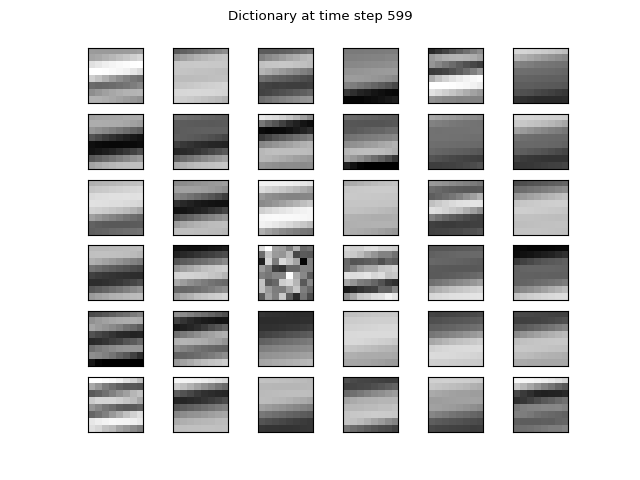

In [7]:
# Initialize some empty arrays to hold network summary statistics
percNonzero = np.zeros(numTrials)
energy = np.zeros(numTrials)
reconQuality = np.zeros(numTrials)

# Initialize Phi weight matrix with random values
phi = hf.l2Norm(np.random.randn(numInputs, numOutputs))

# Do sparse coding with LCA
prevFig = pf.plotDataTiled(phi[:,:50], "Dictionary at time step 0", None)
for trial in range(numTrials):
    # Make batch of random image patches
    patchBatch = np.zeros((numInputs, batchSize))
    for batchNum in range(batchSize):
        numSongs = dataset.shape[1]
        song = dataset[:, np.random.randint(0, numSongs)]
        numPixels = song.shape[0]
        randStart = np.random.randint(0, numPixels - numInputs)
        patchBatch[:, batchNum] = song[randStart:randStart+numInputs]
        
    if trial > 200:
        strict = True
    else:
        strict = False
    # Compute sparse code for batch of image patches
    sparseCode = lcaSparsifyAudio(patchBatch, phi, tau, sparsityTradeoff, numSteps, False)
    
    # Update weights using inferred sparse code
    learningRate = eta / batchSize
    (phi, reconError) = lcaLearn(phi, patchBatch, sparseCode, learningRate)
    
    # Renormalize phi matrix
    phi = hf.l2Norm(phi)
    
    # Record some stats for plotting
    percNonzero[trial] = 100 * np.count_nonzero(sparseCode) / sparseCode.size
    energy[trial] = (np.mean(0.5 * np.sum(np.power(reconError, 2.0), axis=0))
        + sparsityTradeoff * np.mean(np.sum(np.abs(sparseCode), axis=0)))
    MSE = np.mean(np.power(reconError, 2.0))
    reconQuality[trial] = 10 * np.log(1**2 / MSE)
    
    if trial % displayInterval == 0:
#         print("HERE")
        prevFig = pf.plotDataTiled(phi[:,:50], "Dictionary at time step "+str(trial), prevFig)
    
# Plot learned dictionary
prevFig = pf.plotDataTiled(phi[:,:50], "Dictionary at time step "+str(trial), prevFig)

<IPython.core.display.Javascript object>


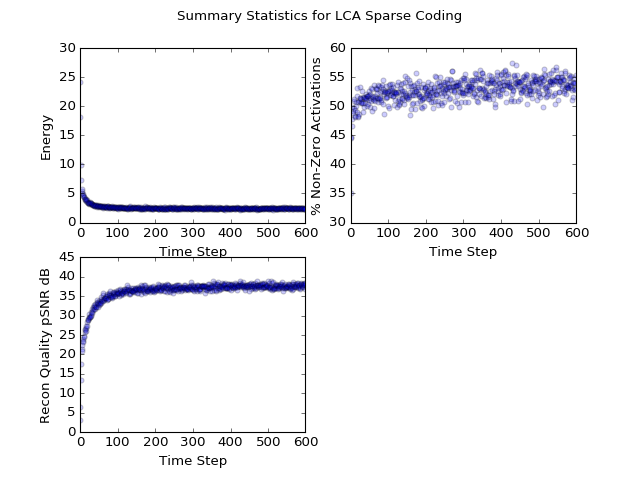

In [8]:
# Plot learning summary statistics
dataList = [energy, percNonzero, reconQuality]
labelList = ["Energy", "% Non-Zero Activations", "Recon Quality pSNR dB"]
title = "Summary Statistics for LCA Sparse Coding"
pf.makeSubplots(dataList, labelList, title)

(2043904,)
song shape(262144,)
(64, 4096)
(125737,)
sparse shape: (36, 4096)
phi shape: (64, 36)
reconBatch shape: (64, 4096)


<IPython.core.display.Javascript object>


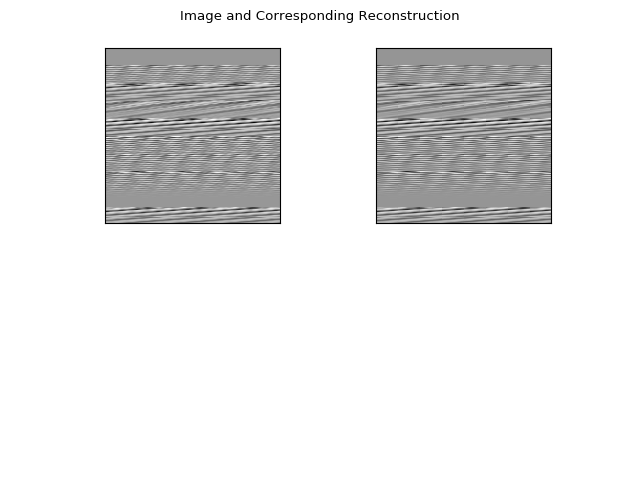

In [9]:
# Reconstruct an image
# image = originalDataset[:,0] / whitenFactor
# numAudioPixels = dataset.shape[0]*dataset.shape[1]
# song = dataset[:,0]
# print(dataset.shape)
# for x in range(1, dataset.shape[1]):
#     print(x)
#     song = np.hstack(dataset[:,x])
# song = dataset.reshape((numAudioPixels,))
song = songs
print(song.shape)
song = song[:(512**2)]
imgPixels = song.size
# print(imgPixels)
# print(numInputs)
numPatches = int(imgPixels/numInputs) # must divide evenly
# patchBatch = image.reshape(numPatches, numInputs).T
# print(patchBatch.shape)


patchBatch = np.zeros((numInputs, numPatches))
print("song shape" + str(song.shape))
print(patchBatch.shape)
i = 0
for patchNum in range(numPatches):
    patchBatch[:, patchNum] = song[i:i+numInputs]
    i += numInputs
    
sparseCode = np.zeros((numOutputs, numPatches))
sparseCode = lcaSparsifyAudio(patchBatch, phi, tau, sparsityTradeoff, numSteps, strict=False)
print(np.unique(sparseCode).shape)
print("sparse shape: " + str(sparseCode.shape))
print("phi shape: " + str(phi.shape))
reconBatch = phi @ sparseCode
print("reconBatch shape: " + str(reconBatch.shape))
reconImage = reconBatch.T.reshape((reconBatch.shape[0]*reconBatch.shape[1],))
imgAndRecon = np.vstack((song, reconImage)).T
pf.plotDataTiled(imgAndRecon, "Image and Corresponding Reconstruction");

<IPython.core.display.Javascript object>


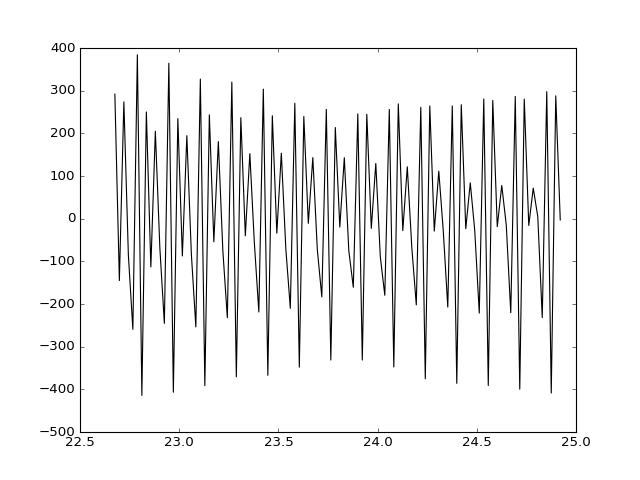

In [24]:
timeArray = np.array(range(0, sparseCode.shape[1]))
timeArray = timeArray / rate
timeArray = timeArray * 1000  #scale to milliseconds
plt.figure()
plotRange = range(1000, 1100)
plt.plot(timeArray[plotRange], sparseCode[0, plotRange], color='k')
# ylabel('Amplitude')
# xlabel('Time (ms)')

In [527]:
print(patchBatch.shape)
print(reconBatch.shape)
print(reconImage.shape)

(16384, 64)
(16384, 64)
(1048576,)


In [25]:
print(np.unique(reconImage).shape)
print(reconImage)
print(whitenFactor)
originalData = (reconImage).astype(np.int16)
# originalData = originalData[::-1]
# print(originalData.shape)
# print(originalData.dtype)
# print(rate)
wav.write('test.wav', rate, originalData)

(224257,)
[   0.            0.            0.         ..., -141.1383374  -163.75725639
 -190.69964874]
648.616044283


In [26]:
IPython.display.Audio("test.wav")

In [375]:
print(reconImage.shape)

(262144,)


In [376]:
# transitionTable = dict()
# print(sparseCode.shape)
# prevColWinner = np.argmax(sparseCode, 0)
# print(np.max(prevColWinner))
# for colIndex in range(1, sparseCode.shape[1]): #starting at second row
#     colWinner = np.argmax(sparseCode[:, colIndex])
#     assert(colWinner <= numOutputs)
# #     print(colWinner)
# #     if prevColWinner in transitionTable:
# #         transitionTable[prevColWinner][colWinner] += 1
# #         if colWinner in transitionTable[prevColWinner]:
# # #             transitionTable[prevColWinner][colWinner] += 1
# #         else:
# # #             transitionTable[prevColWinner][colWinner] = 1
#     if prevColWinner not in transitionTable:
#         transitionTable[prevColWinner] = np.zeros((numOutputs,))
#     transitionTable[prevColWinner][colWinner] += 1
# #         transitionTable[prevColWinner] = dict()
# #         transitionTable[prevColWinner][colWinner] = 1   
#     prevColWinner = colWinner

In [92]:
# markovChain is dict mapping history -> next state
def generateMarkovChain(order, sequence):
    
    markovChain = dict()
    history = tuple(sequence[:order])
    sequenceLength = len(sequence)
    stateSpaceSize = numOutputs #np.unique(songSequence).shape[0]
    
    for i in range(order, sequenceLength):
        currElement = sequence[i]
        if history not in markovChain:
            markovChain[history] = np.zeros((stateSpaceSize,))
        markovChain[history][currElement] += 1
        history = history[1:] + (currElement,)
        
    
    return markovChain

In [ ]:
# def generateNewSequence(markovChain, newLength, random=True):
    

In [93]:
songSequence = np.argmax(sparseCode, 0)
transitionTable = generateMarkovChain(4, songSequence)

In [97]:
random_seed = random.sample(transitionTable.keys(), 1)[0]
newSongSize = 1000000 
realizableSize = newSongSize - (newSongSize % numInputs)
generatedSong = np.zeros((realizableSize,))
prevGlobHistory = random_seed
numRandom = 0
for i in range(int(realizableSize/numInputs)):
#     print("HERE")
    start = numInputs*i
    end = numInputs*i + numInputs 
    if prevGlobHistory in transitionTable:
        possibleNextGlobIndices = transitionTable[prevGlobHistory]
        landing_point = np.random.randint(0, np.sum(possibleNextGlobIndices))
        running_sum = 0
        currentGlobIndex = 0
        while running_sum < landing_point:
            running_sum += possibleNextGlobIndices[currentGlobIndex]
            currentGlobIndex += 1
    else:
        numRandom += 1
        currentGlobIndex = random.sample(transitionTable.keys(), 1)[0][0]
    
#     maxLikelihood = 0
#     for nextGlobIndex in possibleNextGlobIndices:
#         if possibleNextGlobIndices[nextGlobIndex] > maxLikelihood:
#             maxLikelihood = possibleNextGlobIndices[nextGlobIndex]
#             currentGlobIndex = nextGlobIndex
    generatedSong[start:end] = phi[:, currentGlobIndex]
    prevGlobHistory = prevGlobHistory[1:] + (currentGlobIndex,)
print("number of random paths taken: " + str(numRandom))

number of random paths taken: 15551


In [100]:
print(np.unique(generatedSong).shape)
generatedSongUnWhitened = (generatedSong).astype(np.int16)
wav.write('generated.wav', rate, generatedSongUnWhitened)

(2240,)


In [101]:
IPython.display.Audio("generated.wav")